# **Salary Prediction - social network ads**

* Gender
* Age
* EstimatedSalary
* Purchased

## **1. Import Necessary Libraries**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

## **2. Data Preprocessing**

In [2]:
# Load the data
df=pd.read_csv('/content/drive/MyDrive/FSDS @Kodi Senapati/Colab files/MachineLearning/Datasets/Social_Network_Ads.csv')

df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [4]:
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [5]:
# Drop  the irrelevant column

print(len(df.columns))
df.drop(columns=['User ID'], inplace=True)
print(len(df.columns))

5
4


In [6]:
# Missing values & duplicates check

df.isnull().sum()

,0
Gender,0
Age,0
EstimatedSalary,0
Purchased,0


# **3. EDA**

**Distributions for Age, EstimatedSalary**

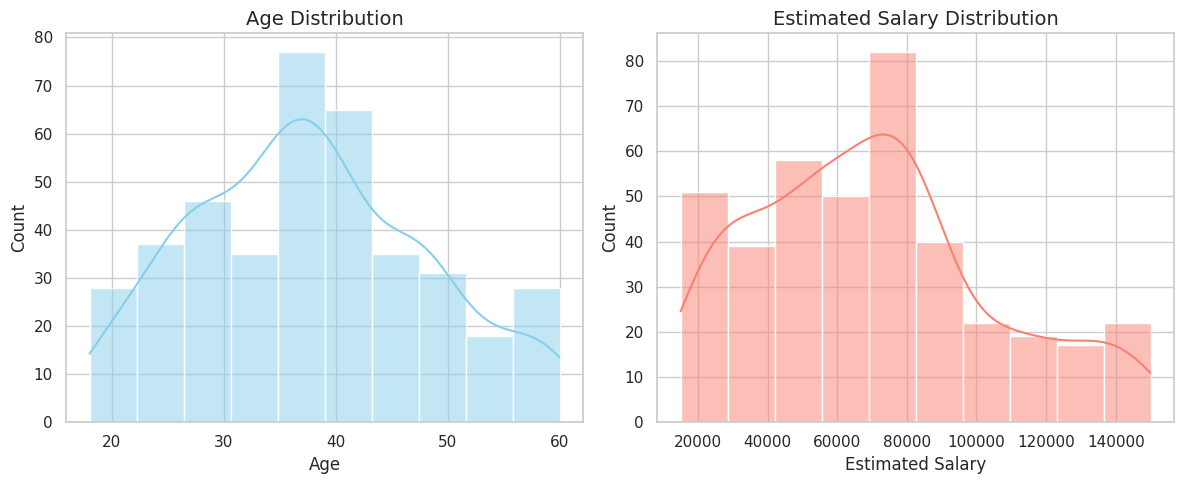

In [ ]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Age distribution
sns.histplot(df['Age'], kde=True, bins=10, color='skyblue', ax=axes[0])
axes[0].set_title('Age Distribution', fontsize=14)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# EstimatedSalary distribution
sns.histplot(df['EstimatedSalary'], kde=True, bins=10, color='salmon', ax=axes[1])
axes[1].set_title('Estimated Salary Distribution', fontsize=14)
axes[1].set_xlabel('Estimated Salary')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Countplot for Purchased**

/tmp/ipython-input-3809420190.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Purchased', data=df, palette='Set2')


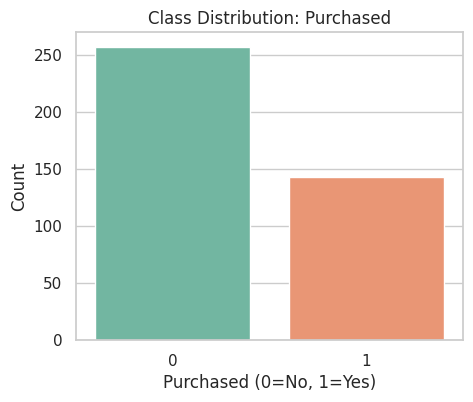

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='Purchased', data=df, palette='Set2')
plt.title('Class Distribution: Purchased')
plt.xlabel('Purchased (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

**Boxplots**

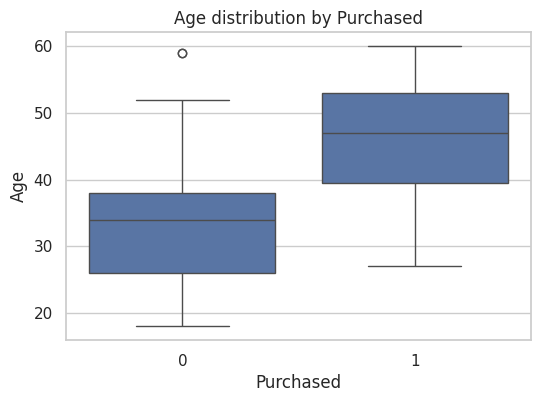

In [ ]:
# Boxplot for Age vs Purchased

plt.figure(figsize=(6,4))
sns.boxplot(x='Purchased', y='Age', data=df)
plt.title('Age distribution by Purchased')
plt.show()

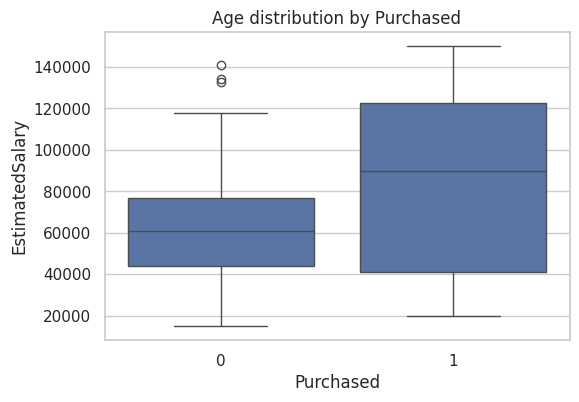

In [ ]:
# Boxplot for EstimatedSalary vs Purchased

plt.figure(figsize=(6,4))
sns.boxplot(x='Purchased', y='EstimatedSalary', data=df)
plt.title('Age distribution by Purchased')
plt.show()

# **4. Feature Engineering**

**Split to train and test**

In [7]:
# Separate features & target
X = df.drop(columns=['Purchased'])
y = df['Purchased']

# Train-test split FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Encode Gender**

In [8]:
# Encode Gender Column
label_encoder=LabelEncoder()
X_train['Gender']=label_encoder.fit_transform(X_train['Gender'])
X_test['Gender']  = label_encoder.transform(X_test['Gender'])

print("X_train after encoding:\n", X_train.head())
print("\nX_test after encoding:\n", X_test.head())

X_train after encoding:
      Gender  Age  EstimatedSalary
65        1   24            58000
179       0   31            34000
109       0   38            80000
379       0   58            23000
325       0   41            60000

X_test after encoding:
      Gender  Age  EstimatedSalary
331       0   48           119000
92        1   26            15000
1         1   35            20000
234       0   38           112000
136       0   20            82000


**Standardize numeric columns**

In [9]:
scaler = StandardScaler()
num_cols = ['Age', 'EstimatedSalary']

# Fit only on training numeric columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

**Apply SMOTE on training set only**

In [10]:
# Check imbalance before SMOTE
print("Class distribution BEFORE SMOTE:")
print(Counter(y_train))

# Apply SMOTE only on training data ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Check balance after SMOTE ---
print("\nClass distribution AFTER SMOTE:")
print(Counter(y_train_bal))

Class distribution BEFORE SMOTE:
Counter({0: 206, 1: 114})

Class distribution AFTER SMOTE:
Counter({0: 206, 1: 206})


## **5. Model Training**

**Logistic Regression**

In [16]:
# Model Definition
log_reg=LogisticRegression()

**Cross-Validation on SMOTE balanced data**

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    log_reg,
    X_train_bal,
    y_train_bal,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False
)

print("Cross-validation results (mean):")
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']:
    print(f"{metric}: {np.mean(cv_results[metric]):.4f}")

Cross-validation results (mean):
test_accuracy: 0.8520
test_precision: 0.8584
test_recall: 0.8446
test_f1: 0.8505
test_roc_auc: 0.9301


**Train on full SMOTE-balanced training set**

In [18]:
log_reg.fit(X_train_bal, y_train_bal)

# Predictions on original test set
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

In [19]:
pred=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
pred.head()

,Actual,Predicted
331,1,1
92,0,0
1,0,0
234,0,1
136,0,0


**Evaluation on test set**

In [22]:
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred))

print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.87      0.80      0.84        51
           1       0.70      0.79      0.74        29

    accuracy                           0.80        80
   macro avg       0.78      0.80      0.79        80
weighted avg       0.81      0.80      0.80        80

Test ROC-AUC: 0.9073698444895199


* Class 0 (Non-buyers)
  * Precision 0.87 → When the model predicts "won’t purchase", it’s correct 87% of the time.
  * Recall 0.80 → It catches 80% of all the actual non-buyers.
* Class 1 (Buyers)
  * Precision 0.70 → When the model predicts "will purchase", 70% are actually buyers (so ~30% are false positives).
  * Recall 0.79 → It correctly identifies 79% of all actual buyers.

* Overall
  * Accuracy: 80% → 4 out of 5 predictions are correct.
  * Macro avg F1: 0.79 → Balanced performance across both classes.
  * ROC-AUC: ~0.91 → Very strong ranking ability, consistent with cross-validation results.


**ROC Curve**

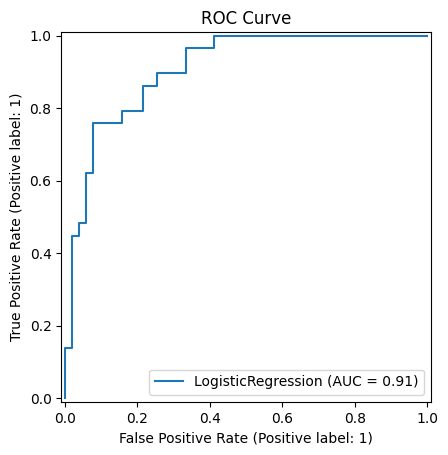

In [24]:
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve")
plt.show()

* AUC = 0.91 → This means the model is very good at separating buyers from non-buyers.
* The curve is well above the diagonal (random guess line), which confirms strong discrimination power.
* The steep initial climb on the left means the model achieves high recall with a low false positive rate at certain thresholds.

In short: This is a high-performing Logistic Regression model.

**Hyperparameter tuning**

In [26]:
# Hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Types of regularization
    'solver': ['liblinear', 'saga'],  # Saga supports elasticnet
    'l1_ratio': [0, 0.5, 1]  # Only used for elasticnet (ignored otherwise)
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',  # You can change to 'accuracy', 'roc_auc', etc.
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_bal, y_train_bal)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (F1):", grid_search.best_score_)

# Evaluate on test set
best_log_reg = grid_search.best_estimator_
y_pred_test = best_log_reg.predict(X_test)
y_prob_test = best_log_reg.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred_test))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'C': 0.1, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Score (F1): 0.8776924799788661

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        51
           1       0.66      0.86      0.75        29

    accuracy                           0.79        80
   macro avg       0.78      0.80      0.78        80
weighted avg       0.82      0.79      0.79        80

Test ROC-AUC: 0.90736984448952


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
75 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

**Reasons for warnings:**

* Some combinations in your grid were invalid.
* For example:
  * penalty='elasticnet' only works with solver='saga'. You tried it with liblinear, which caused those 75 fits to fail.
  * l1_ratio is only used when penalty='elasticnet', so it was ignored in other cases.

**Fixing the issue**
* Filtering parameters so only valid solver–penalty–l1_ratio combos are tested.
* Adding polynomial features as part of the pipeline so tuning will decide whether they help.

In [33]:
# Pipeline: scaling → optional polynomial features → logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('clf', LogisticRegression(max_iter=10000))
])

# Valid solver-penalty combos
param_grid = [
    # solvers supporting L2 penalty
    {
        'poly__degree': [1, 2],  # 1 = no poly, 2 = quadratic
        'clf__solver': ['lbfgs', 'sag', 'newton-cg'],
        'clf__penalty': ['l2'],
        'clf__C': [0.01, 0.1, 1, 10]
    },
    # liblinear supports L1 or L2
    {
        'poly__degree': [1, 2],
        'clf__solver': ['liblinear'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10]
    },
    # saga supports L1, L2, elasticnet (needs l1_ratio for elasticnet)
    {
        'poly__degree': [1, 2],
        'clf__solver': ['saga'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10]
    },
    {
        'poly__degree': [1, 2],
        'clf__solver': ['saga'],
        'clf__penalty': ['elasticnet'],
        'clf__l1_ratio': [0.1, 0.5, 0.9],
        'clf__C': [0.01, 0.1, 1, 10]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred_h = grid.predict(X_test)
y_prob_h = grid.predict_proba(X_test)[:, 1]
print("Test Accuracy:", accuracy_score(y_test, y_pred_h))
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_h))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'poly__degree': 2}
Best CV score: 0.896875
Test Accuracy: 0.9125
Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        51
           1       0.87      0.90      0.88        29

    accuracy                           0.91        80
   macro avg       0.90      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80

Test ROC-AUC: 0.9560513860716701


# **Side-by-side Validation**

**1. Before vs After Hyperparameter Tuning**

| Metric                  | Before Tuning               | After Tuning                                                   |
| ----------------------- | --------------------------- | -------------------------------------------------------------- |
| Best Params             | Default Logistic Regression | `C=0.1`, `penalty='l1'`, `solver='liblinear'`, `poly_degree=2` |
| Cross-Validation Score  | –                           | **0.8969**                                                     |
| **Test Accuracy**       | **0.8000**                  | **0.9125** ✅ (+11.25%)                                         |
| **Precision (Class 0)** | 0.87                        | **0.94**                                                       |
| **Recall (Class 0)**    | 0.80                        | **0.92**                                                       |
| **F1-score (Class 0)**  | 0.84                        | **0.93**                                                       |
| **Precision (Class 1)** | 0.70                        | **0.87**                                                       |
| **Recall (Class 1)**    | 0.79                        | **0.90**                                                       |
| **F1-score (Class 1)**  | 0.74                        | **0.88**                                                       |
| **Macro Avg F1**        | 0.79                        | **0.91**                                                       |
| **ROC–AUC**             | 0.9074                      | **0.9561** ✅ (+0.049)                                          |


**2. Interpretation**
* Accuracy Jump: 0.80 → 0.91 is a substantial improvement (11% absolute gain)
* Balanced Gains: Both classes improved in precision and recall, meaning the model is better at both avoiding false positives and catching true positives.
* ROC–AUC Improvement: From 0.907 → 0.956 means your tuned model is now excellent at ranking predictions.
* Why It Improved:
  * poly_degree=2 captured interactions between Age, Salary, and Gender.
  * l1 penalty performed feature selection on the expanded feature set, removing noisy polynomial terms.
  * Lower C=0.1 added regularization, preventing overfitting.

**Conclusion:**

Your hyperparameter tuning + polynomial features significantly boosted performance on all key metrics, especially for Class 1 (purchasers), which is usually the business-critical class in purchase prediction.

## **Save the model**

**Save (pickle) your best model**

In [34]:
import pickle

# Save the best model
with open("best_model_SocialNetworkAds.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

print("Best model saved as best_model_SocialNetworkAds.pkl")

Best model saved as best_model_SocialNetworkAds.pkl
